# Economic Drivers of Airbnb Pricing in Los Angeles: An Examination of Crime, Demographics, and Geography

---

## Libraries

In [1]:
# Uncomment the line below to install the required packages
# !pip -q install pandas numpy matplotlib scipy shapely geopandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from functions import *

---

## Data Loading and Cleaning

In [3]:
base_url = "http://data.insideairbnb.com/united-states/ca/los-angeles"
df = pd.read_csv(f"{base_url}/2023-12-03/visualisations/listings.csv")
df = merge_past_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61654 entries, 0 to 42448
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              61654 non-null  int64  
 1   name                            61654 non-null  object 
 2   host_id                         61654 non-null  int64  
 3   host_name                       61634 non-null  object 
 4   neighbourhood_group             61654 non-null  object 
 5   neighbourhood                   61654 non-null  object 
 6   latitude                        61654 non-null  float64
 7   longitude                       61654 non-null  float64
 8   room_type                       61654 non-null  object 
 9   price                           61654 non-null  int64  
 10  minimum_nights                  61654 non-null  int64  
 11  number_of_reviews               61654 non-null  int64  
 12  last_review                     42595

In [4]:
# Removing price anomalies
display(len(df[df.price < 30]))
df = df[df.price >= 30]

702

In [5]:
# Dropping columns
df.drop(["id", "name", "host_id", "host_name", "last_review",
         "reviews_per_month", "number_of_reviews_ltm",
         "calculated_host_listings_count"], axis=1, inplace=True)

In [6]:
# Creating new columns
df["log_price"] = np.log(df["price"])
df["has_reviews"] = np.where(df["number_of_reviews"] != 0, 1, 0)
df["has_license"] = np.where(df["license"].notna(), 1, 0)
df["is_short_term"] = np.where(df["minimum_nights"] < 30, 1, 0)
df["is_hol_hills_w"] = np.where(df["neighbourhood"] == "Hollywood Hills West", 1, 0)

# Creating coordinates
df["coordinates"] = list(zip(df.longitude, df.latitude))
df["coordinates"] = df["coordinates"].apply(Point)

# Renaming columns
df.rename(columns={"number_of_reviews": "n_reviews"}, inplace=True)

In [7]:
# Creating a new index for each listing
np.random.seed(12)
new_id = np.random.choice(range(10 ** 4, 10 ** 5), replace=False,
                          size=(1, len(df))).tolist()
df.set_index(new_id, inplace=True)
df.index.rename("id", inplace=True)

In [8]:
# Creating new data frames
cleaned_df = outliers(outliers(df, "minimum_nights", True), "price", True)
cleaned_gdf = gpd.GeoDataFrame(cleaned_df, geometry="coordinates", crs="EPSG:4326")

---

## Summary Statistics

In [9]:
cols = ["price", "n_reviews", "minimum_nights", "availability_365"]

In [10]:
# Summary with outliers
df[cols].describe().round(2)

,price,n_reviews,minimum_nights,availability_365
count,60952.00,60952.00,60952.00,60952.00
mean,290.05,29.57,17.34,197.98
std,1099.54,70.07,26.81,141.16
min,30.00,0.00,1.00,0.00
25%,90.00,0.00,2.00,62.00
50%,148.00,4.00,7.00,213.00
75%,248.00,25.00,30.00,348.00
max,99999.00,2472.00,1124.00,365.00


In [11]:
# Summary without outliers
cleaned_df[cols].describe().round(2)

,price,n_reviews,minimum_nights,availability_365
count,59733.00,59733.00,59733.00,59733.00
mean,225.96,30.04,15.74,197.35
std,272.26,70.63,14.34,140.99
min,30.00,0.00,1.00,0.00
25%,90.00,0.00,2.00,61.00
50%,145.00,4.00,7.00,210.00
75%,240.00,25.00,30.00,347.00
max,2486.00,2472.00,70.00,365.00


---

## Histograms

In [12]:
# Setting fill and edge colors of charts
fill = "#6C4B95"
alt_fill = "#4F954B"
edge = "black"

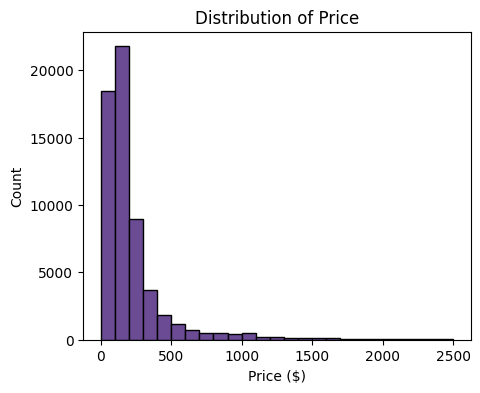

In [13]:
# Plotting
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(cleaned_df["price"], bins=bin_interval(0, 2500, 100),
        edgecolor=edge, color=fill)

# Formatting
ax.set_xticks(bin_interval(0, 2500, 500))
ax.set_title("Distribution of Price")
ax.set_xlabel("Price ($)")
ax.set_ylabel("Count")

plt.show()

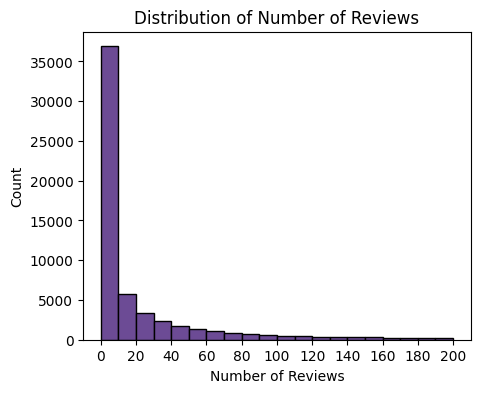

In [14]:
# Plotting
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(cleaned_df["n_reviews"], bins=bin_interval(0, 200, 10),
        edgecolor=edge, color=fill)

# Formatting
ax.set_xticks(bin_interval(0, 200, 20))
ax.set_title("Distribution of Number of Reviews")
ax.set_xlabel("Number of Reviews")
ax.set_ylabel("Count")

plt.show()

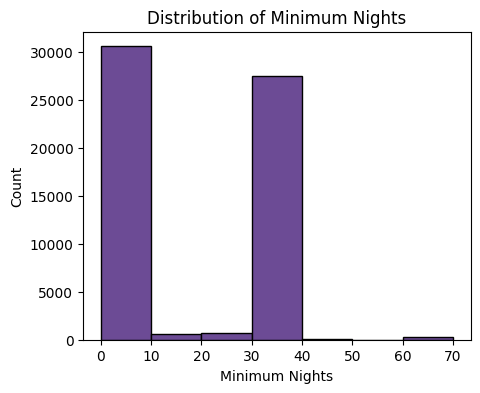

In [15]:
# Plotting
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(cleaned_df["minimum_nights"], bins=bin_interval(0, 70, 10),
        edgecolor=edge, color=fill)

# Formatting
ax.set_xticks(bin_interval(0, 70, 10))
ax.set_title("Distribution of Minimum Nights")
ax.set_xlabel("Minimum Nights")
ax.set_ylabel("Count")

plt.show()

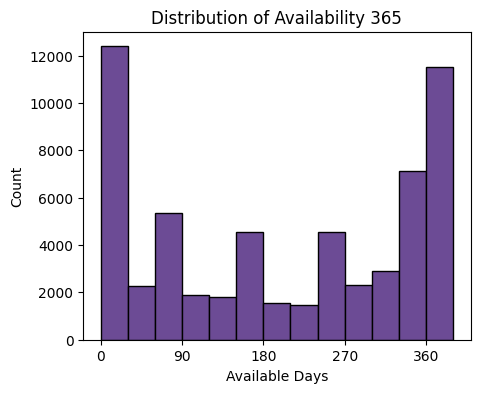

In [16]:
# Plotting
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(cleaned_df["availability_365"], bins=bin_interval(0, 365, 30),
        edgecolor=edge, color=fill)

# Formatting
ax.set_xticks(bin_interval(0, 360, 90))
ax.set_title("Distribution of Availability 365")
ax.set_xlabel("Available Days")
ax.set_ylabel("Count")

plt.show()